# 尺度不变特征变换(Scale-invariant feature transform , SIFT)

# 尺度空间

SIFT算法的第一阶段是找到对尺度变化不变的图像位置。 这是在所有可能的尺度上使用一个称为尺度空间的函数搜索稳定的特征实现的，尺度空间是一种多尺度表示，它以一致的方式处理不同尺度的图像结构。基本思想是以某种形式来处理这样一个事实。由于事先并不知道这些尺度，因此一种合理的方法是同时处理所有相关的尺度。尺度空间将图像表示为平滑后的图像的一个参数族，目的时模拟图像的尺度减小时出现的细节损失。控制平滑的参数成为尺度参数。

在SIFT算法中，高斯核用于实现平滑，因此尺度参数是标准差。使用高斯核的依据是Lindberg的研究成果，他证明只有满足一组重要约束条件的平滑核才是高斯低通核。因此，灰度图像$f(x,y)$的尺度空间
$L(x,y,\sigma )$是$f$与一个可变尺度高斯核$G(x,y,\sigma)$的卷积：
$$
    L(x,y,\sigma) = G(x,y,\sigma) \star f(x,y)
$$

式中，尺度参数$\sigma$控制，G的形式如下：
$$
 G(x,y,\sigma) = \frac{1}{2\pi \sigma} e^{(-x^2 + y^2) / 2\sigma^2}
$$
输入图像$f(x,y)$依次与标准差$\sigma , k\sigma , k^2\sigma,k^3\sigma$的高斯核卷积，生成一堆由常量因子$k$分割的高斯滤波图像。

SIFT 将尺度空间分为倍频程，每个倍频程对应与$\sigma$的加倍，类似与音乐理论中的一个倍频程对应于声音信号的频率倍增。SIFT将每个倍频程进一步细分为整数s个区间，因此区间1由两幅图像组成，区间2由三幅图像组成，以此类推。于是可以证明，在生成与一个倍频程对应的图像的高斯核中，所用的值是$k^s\sigma = 2\sigma$，这意味这$k = 2 ^ {1/s}$。 例如，对于 $s = 2 , k = \sqrt{2}$,并且连续地使用标准差$\sigma , \sqrt{2}\sigma , (\sqrt(\sigma))^2$来平滑图像，以便使用标准差为$\sqrt{2}^2\sigma = 2\sigma$的高斯核对序列中的第三副图像(即 s = 2 的倍频程)进行滤波。



In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.ndimage as ndimage
import cv2

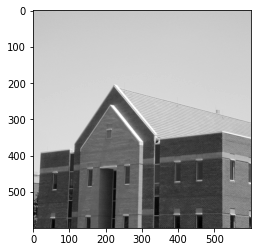

In [2]:
f = plt.imread("./../images/building-600by600.tif")
plt.imshow(f , "gray")

In [3]:

def create_guassian_pyramid(f , s = 2 , sigma = 1.6 , n_ocatives = None ):
    h,w = f.shape 
    if n_ocatives is None:
        n_ocatives = np.log2(min(h,w)) - 3        
    k = pow(2 , 1/s)   
    gc = s + 2
    gs = []
    temp = []
    for cloth in range(gc):
        g =  ndimage.gaussian_filter(f , pow(k , cloth) * sigma)
        temp.append(g)    
    if n_ocatives > 1 :
        gs = gs + (create_guassian_pyramid(cv2.resize(temp[-3],(int(h/2) , int(w/2))) , s , sigma , n_ocatives = n_ocatives - 1 ))
    gs.append(temp)
    return gs 

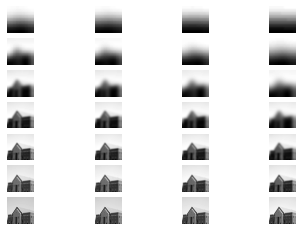

In [4]:
gp = create_guassian_pyramid(f)
o  = len(gp)
c = len(gp[0])

j = 0
for gs in gp:   
    for g in gs:        
        ax = plt.subplot(o , c , j + 1 )
        ax.axis("off")
        # w = 300 if 300 < g.shape[0] else g.shape[0] 
        # y = 300 if 300 < g.shape[1] else g.shape[1] 
        # ax.figure.set_figheight(w)
        # ax.figure.set_figwidth(y)        
        # ax.figure = g.shape
        j = j + 1     
        plt.imshow(g , cmap="gray")   


# 检测局部极值

SIFT最初使用高斯滤波后的图像来查找关键点的位置，然后使用两个处理步骤来改善这些关键点的位置和正确性。_

尺度空间中关键点的位置最初由SIFT找到，方法是首先检测一个倍频程中两幅相邻尺度空间图像的高斯差的极值，然后与对应于这个倍频程的输入图像进行卷积。例如，要查找与尺度空间中倍频程1的前两层相关的关键点的位置，可查找如下函数中的极值:
$$
    D(x,y,\sigma) = [G(x,y,k\sigma) - G(x,y,\sigma)]\star f(x,y)

    D(x,y,\sigma) = L(x,y,k\sigma) - L(x,y,\sigma)
$$
还句话说要形成$D(x,y,\sigma)$，就必须减去倍频程1的前两幅图像。高斯差是高斯-拉普拉斯(LoG)的一个近似。因此
$$
    G(x,y,l\sigma) - G(x,y,\sigma) \approx ( k - 1)\sigma^2 \bigtriangledown^2G
$$

因此DoG已经内置了必要的尺度。

SIFT用来查找图像$D(x,y,\sigma)$中的极值过程。在$D(x,y,\sigma)$图像中的每个位置，将该位置的像素值与其在当前图像中的8个相邻像素值及其上方和下方图像中的9个相邻元素进行比较。如果该位置的值大于其所有相邻像素的值，或小于所有相邻像素的值，那么该位置被选为极值(最大值或最小值)点。

In [5]:
# 高斯差分金字塔
dog = []
for gs in gp :
    temp = []
    for idx , g in enumerate(gs) : 
        if idx == 0:
            continue;
        difference = g - gs[idx - 1]
        temp.append(difference)
    dog.append(temp)


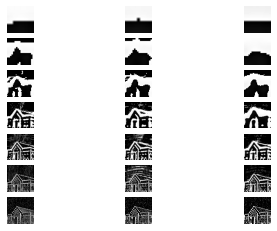

In [6]:
o  = len(dog)
c = len(dog[0])
j = 0
for gs in dog:   
    for g in gs:        
        ax = plt.subplot(o , c , j + 1 )
        ax.axis("off")        
        j = j + 1     
        plt.imshow(g , cmap="gray")         


In [7]:
extremes = []
# 比对高斯金字塔的极值
for group in dog : 
    temp = []
    for idx , g in enumerate(group):
        if idx == 0:
            continue ;
        if idx + 1 == len(group):
            continue;
        pre_g = group[idx - 1]
        next_g =group[idx + 1]
        h, w = g.shape 
        for y in range(h):
            for x in range(w):
                current = g[y][x]
                is_extreme = True
                for offset_h in range(-1, 1):
                    if is_extreme is False:
                        break
                    for offset_w in range(-1 , 1):
                        offset_y = offset_h + y 
                        offset_x = offset_w + x
                        if(offset_x < 0 or offset_x >= w or offset_y <0 or offset_y >=h):
                            continue
                        pixel_top = next_g[offset_y][offset_w]
                        pixel_bottom = pre_g[offset_y][offset_w]
                        pixel = g[offset_y][offset_x]
                        if(pixel_top >= current or pixel_bottom >= current or (pixel >= current and (offset_x != x and offset_y != y))):
                            is_extreme = False 
                            break 
                if is_extreme is True:
                    temp.append([y,x])
        extremes.append(temp)


In [8]:
extremes_pic = []
# 查看极值点
for index , group in enumerate(extremes):    
    h,w = dog[index][0].shape
    g = np.zeros((h,w))
    for points in group:
        y,x = points 
        g[y][x] = 255    
    extremes_pic.append(g)

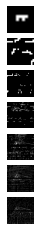

In [9]:
# 打印极值点图像
o  = len(extremes_pic)
j = 0

for g in extremes_pic:          
        ax = plt.subplot(o , 1 , j + 1 )
        ax.axis("off")        
        j = j + 1     
        plt.imshow(g , cmap="gray")


## 改进关键点位置的精度

一个连续函数被取样时，它真正的最大值或最小值实际上可能位于样本点之间。得到接近真实极值的一种方法是，首先在数字函数中的每个极值点处拟合一个内插函数，然后在内插后的函数中查找改进精度后的极值位置。SIFT用$D(x,y,\sigma)$的泰勒级数张开的线性项和二次项，把原点移至被检测的样本点，这个公式的向量形式为：
$$
    D(x) = D + (\frac{\partial D}{\partial x})^T + \frac{1}{2}x^T(\frac{\partial D}{\partial x})x  = D + (\triangledown D)^Tx + \frac{1}{2}x^THx
    
$$

式中，D及其导数在这个样本点处计算的，$x = (x, y,\sigma)^T$是这个样本点的偏移量，$\triangledown$是我们熟悉的梯度算子， 
$$
    \triangledown D =  \frac{\partial D}{\partial x} = \begin{bmatrix} 
    \partial D / \partial x \\    
    \partial D / \partial y \\ 
    \partial D / \partial \sigma
    \end{bmatrix}
$$

H是海森矩阵，
$$
    H = \begin{bmatrix}
    \partial^2D / \partial x^2 \quad \partial^2D / \partial x \partial y  \quad \partial^2D / \partial x \partial \sigma \\ 
    \partial^2D / \partial y \partial x  \quad \partial^2D / \partial y^2  \quad \partial^2D / \partial y \partial \sigma \\
    \partial^2D / \partial \sigma \partial x \quad  \partial^2D / \partial \sigma \partial y \quad    \partial^2D / \partial \sigma^2
    \end{bmatrix}
$$
关于x的到户并令其为0 ， 可得极值$\hat{x}$ , 即：
$$
    \hat{x} = -H^{-1}{\triangledown D}
$$

SIFT使用极值位置的函数值$D(\hat{x})$来剔除具有低对比度的不稳定极值
$$
    D(\hat{x}) = D + \frac{1}{2}(\triangledown D)^T\hat{x}
$$

## 消除边缘响应 
使用高斯差会得到图像中的边缘。但SIFT中我们感兴趣的是角状的特征，这些特征更加局部化。图像中的某点的曲折度可由该点处的$2 \times 2$的海森矩阵算出。
$$
    H = \begin{bmatrix} 
    D_{xx} D_{xy} \\
    D_{yx} D_{yy} 
    \end{bmatrix}
$$
利用H矩阵的特征值和行列式之间的关系
$$
    Tr(H) = D_{xx} + D_{yy} = \alpha + \beta
    Det(H) = D_{xx}D_{yy} - (D_{xy})^2 + \alpha \beta 
$$
诺行列式的负的，则不同曲则度具有不同的符号，且讨论的关键点不可能是一个极值，因此丢弃。
令r表示最大特征值与最小特征值之比，于是由$\alpha = r \beta$
$$
    \frac{[Tr(H)]^2}{Det(H)} = \frac{(\alpha + \beta)^2}{\alpha + \beta} = \frac{(r\beta + \beta) ^ 2}{r \beta ^2} = \frac{(r + 1) ^ 2} {r}
$$
因此要检查低于某个阈值r的主曲折度之比，只需检查:
$$
    \frac{[Tr(H)]^2}{Det(H)} < \frac{(r + 1)^2}{r}
$$

In [ ]:
def adjust_local_extrema(dog,o,s,x,y , cthreahold = 0.03 , ethreadshold , sigma):
    SIFT_MAX_INTER_STEPS = 5 
    SIFT_IMG_BORDER = 5 
    point = []
    img = dog[o][s]
    i = 0
    while i < SIFT_MAX_INTER_STEPS:
        if s < 1 or s > n or y <SIFT_IMG_BORDER or x >= img.shape[1] - SIFT_IMG_BORDER
 or y < SIFT_IMG_BORDER or y >= img.shape[0] - SIFT_IMG_BORDER :
        return None,None,None,None
        img = dog[o][s]
        prev = dog[o][s -  1]
        next = dog[o][s + 1]
        dD = [
            img[y + 1 , x]  - img[y-1,x],
            img[y , x + 1] - img[y , x - 1]
            next[y,x] - prev[y,x]
        ]

        v2 = img[y,x] * 2 
        dyy = (img[y + 1 , x] + img[y- 1,x] - v2) * 1/2
        dxx = (img[y , x + 1 ] + img[y,x - 1] - v2) * 1/2 
        dss = (next[x,y] + prev[x,y] - v2) *  1 / 2

        dxy = (img[y + 1 , x + 1] - img[y - 1 , x + 1] - img[y + 1, x - 1] + img[y - 1 ,x - 1]) * 0.125 
        dxs = (next[y + 1 , x] - next[y-1 ,x ] - prev[y + 1, x] + prev[y - 1, x]) * 0.125
        dys = (next[y , x  + 1] - next[y , x - 1] - prev[y , x + 1] + prev[y,x - 1]) * 0.125

        H = [[dxx , dxy , dxs],
            [dxy , dyy , dys], 
            [dxs , dys , dss]]
        X  = np.matmul(np.linalg.pinv(np.array(H) , np.array(dD)))

        xi = -X[2]
        xr = -X[1]
        xc = -X[0]

        if np.abs(xi) < 0.5 and np.abs(xr) < 0.5 and np.abs(xc) < 0.5:
            break 
        y += int(np.round(xc))
        x += int(np.round(xr))
        s += int(np.round(xi))

        i += 1

        if i >= SIFT_MAX_INTER_STEPS:
            return None , x, y, s 
        if s < 1 or s > n or y <SIFT_IMG_BORDER or x >= img.shape[1] - SIFT_IMG_BORDER
 or y < SIFT_IMG_BORDER or y >= img.shape[0] - SIFT_IMG_BORDER :
        return None,None,None,None 

        t = np.array(dD)).dot(np.array[xc , xr,xi])
        contr = img[x,y] + 0.5 * t

        if np.abs(contr) * n < cthreshold : 
            return None , x , y, s
        tr  = dxx + dyy 
        det = dxx * dyy  - dxy * dxy 

        if det <= 0 or tr * tr * ethread >=(ethreadshold + 1 )*(ethreadshold) * det:
            return None , x, y , s
        point.append((x + xr) *(1 << o))
        point.append((y + xc) * (1<<o))
        point.append(o + (s << 8) + int(np.round((xi + 0.5))* 255) << 16))
        return point , x, y, s 